# Выбор локации для скважины

## Введение

Заказчик исследования - добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Ход исследования

#### Загрузка и подготовка данных

Данные геологоразведки трёх регионов находятся в файлах:

- /datasets/geo_data_0.csv
- /datasets/geo_data_1.csv
- /datasets/geo_data_2.csv

id — уникальный идентификатор скважины;

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

product — объём запасов в скважине (тыс. баррелей).

#### Построение модели

1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучить модель и сделать предсказания на валидационной выборке.
3. Сохранить предсказания и правильные ответы на валидационной выборке.
4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.
5. Проанализировать результаты.

#### Подготовка к расчёту прибыли

1. Все ключевые значения для расчётов сохранить в отдельных переменных.
2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
3. Написать выводы по этапу подготовки расчёта прибыли.

#### Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

1. Выбрать скважины с максимальными значениями предсказаний.
2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитать прибыль для полученного объёма сырья.

#### Посчитать риски и прибыль для каждого региона

### Дополнительная информация

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Первичное изучение данных

In [1]:
# Импорты

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats as st

In [2]:
# Загрузка файлов

df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
df_1

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [4]:
df_2

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [5]:
df_3

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Рассмотрим параметры данных в столбцах.

In [6]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
df_3.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Данные выглядят корректными, но разбросы отличаются между регионами. Рассмотрим распределения.

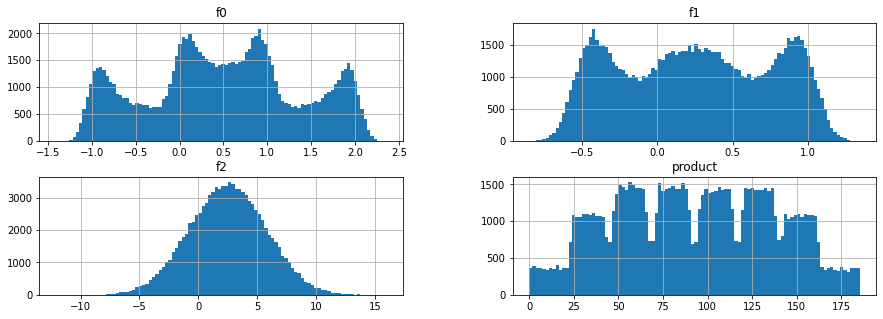

In [9]:
df_1.hist(bins=100, figsize=(15,5));

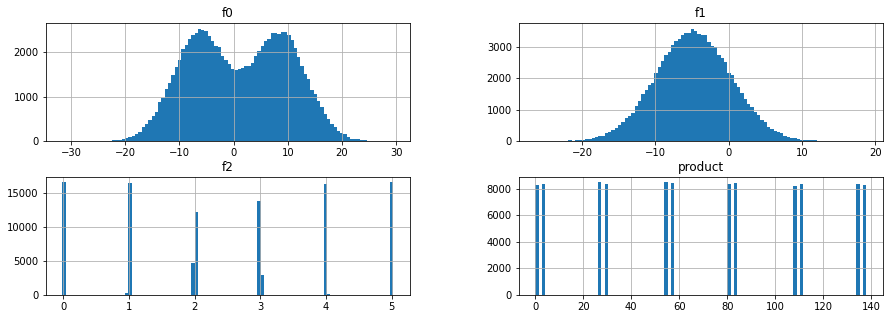

In [10]:
df_2.hist(bins=100, figsize=(15,5));

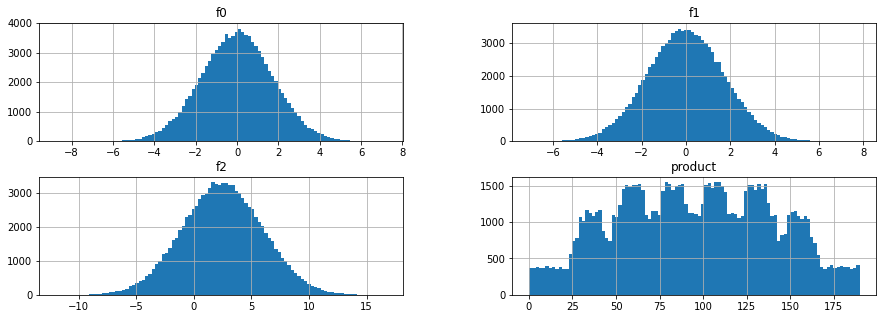

In [11]:
df_3.hist(bins=100, figsize=(15,5));

Распределения в разных регионах различаются. Диапазоны также отличны. Принимаем решение не стандартизировать данные, так как веса могут быть важны - в разных регионах могут быть действительно сильно различные показатели одного параметра. Параметры завуалированы, поэтому мы не можем гарантировать целесообразность стандартизации.

Также имеем предположение, что данные уже стандартизированы, так как многие первичные параметры скважин, имеющие значение в нефтедобывающей сфере, не имеют подобных размеров, разбросанных около нуля (вряд ли глубина месторождения ложится в диапазон 0±6 ед. или содержание воды измеряется в 2±13 ед.).

Несмотря на то, что распределения похожи на нормальные, посмотрим, имеются ли выбросы:

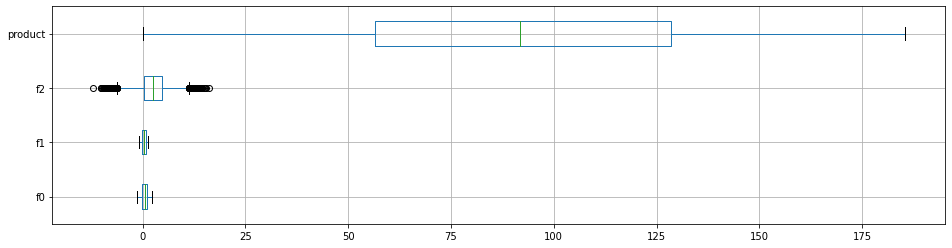

In [12]:
df_1.boxplot(figsize=(16, 4), vert=0);

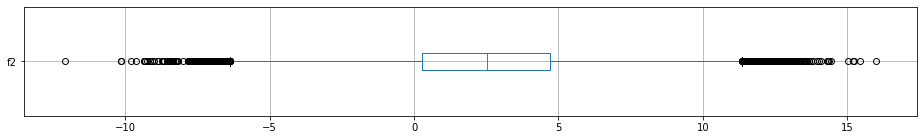

In [13]:
# Выбросы есть только в столбце f2, рассмотим поближе

df_1.boxplot('f2', figsize=(16, 2), vert=False);

Проведём аналогичные операции для остальных датасетов.

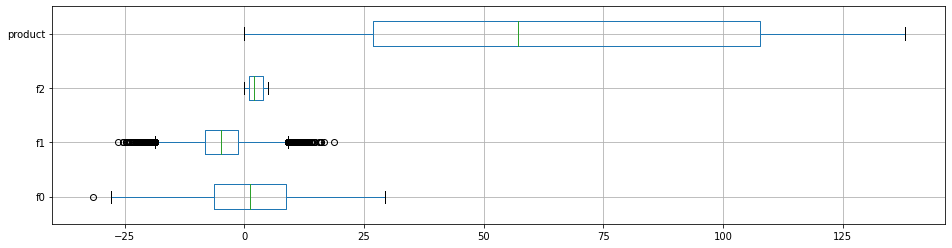

In [14]:
df_2.boxplot(figsize=(16, 4), vert=0);

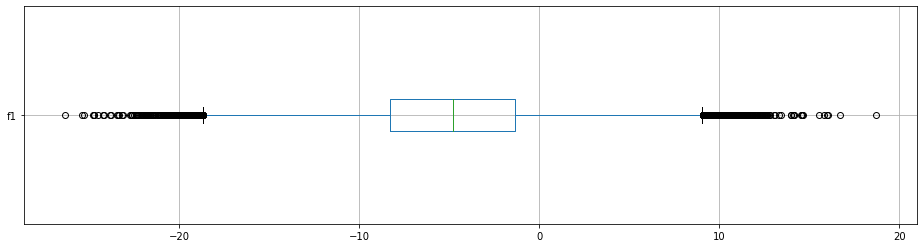

In [15]:
df_2.boxplot('f1', figsize=(16, 4), vert=False);

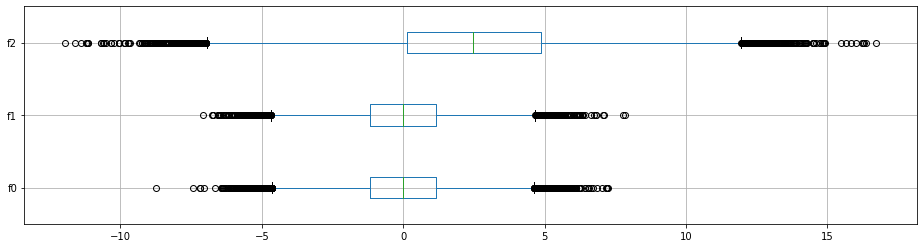

In [16]:
df_3.boxplot(['f0', 'f1', 'f2'], figsize=(16, 4), vert=0);

Выбросы плотно сконцентрированы, но есть и оторванные от общей массы значения. Так как нам неизвестна природа признаков f0, f1, f2, можем только предположить: для выбора нефтяной скважины могут иметь значения такие параметры, как глубина месторождения, давление, содержание воды в добываемой жидкости, возраст отложений и т.д. Параметры, полученные напрямую или косвенно приборными измерениями, имеют погрешность. Данных достаточно для проведения качественного анализа, поэтому можем рассмотреть удаление части выбросов перед дальнейшей работой. Решение примем далее в ходе изучения данных.

Распределение данных во втором регионе сильно отличается от других регионов. Заметно, что аномалия касается столбца `f2` и `product`. Построим матрицы корреляций:

In [17]:
df_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [18]:
df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [19]:
df_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Действительно, для второго региона задачу можно считать решённой без машинного обучения - существует прямая зависимость целевого признака `product` от признака `f2`. В остальных случаях такой сильной зависимости нет. Учтём это в дальнейшей работе.

In [20]:
# Ищем дубли

print(df_1.duplicated().sum())
print(df_2.duplicated().sum())
print(df_3.duplicated().sum())

0
0
0


In [21]:
# Ищем аномалии в типах и пропуски

print(df_1.info())
print(df_2.info())
print(df_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

In [22]:
# Ищем дубли в id

print(df_1['id'].value_counts())
print(df_2['id'].value_counts())
print(df_3['id'].value_counts())

TtcGQ    2
fiKDv    2
74z30    2
bsk9y    2
Tdehs    2
        ..
Sj80T    1
UQTcR    1
hJPzH    1
Cl0he    1
7GkWe    1
Name: id, Length: 99990, dtype: int64
5ltQ6    2
LHZR0    2
bfPNe    2
wt4Uk    2
wToig    1
        ..
mf4ro    1
l08PY    1
JPMhL    1
vPL84    1
Ivqak    1
Name: id, Length: 99996, dtype: int64
Vcm5J    2
KUPhW    2
VF7Jo    2
xCHr8    2
lP7GO    1
        ..
Gm9E0    1
6OcCJ    1
bIqqS    1
jz6bf    1
K5UZL    1
Name: id, Length: 99996, dtype: int64


Некоторые id дублируются. Проверим выборочно строки с дублирующимися id.

In [23]:
df_1.query('id == "QcMuo"')

,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


In [24]:
df_2.query('id == "5ltQ6"')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [25]:
df_3.query('id == "KUPhW"')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


Показатели f0, f1, f2 и объём нефти сильно отличаются для одного и того же id. Также видна зависимость - чем больше некоторые значения показателей `f`, тем выше `product`. Возможно, были проведены измерения в одной скважине, но в разное время (до/после/во время бурения). 

### Предобработка данных

Так как id не является признаком, влияющим на добычу нефте, избавляемся от соответствующего столбца.

In [26]:
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)
df_3 = df_3.drop('id', axis=1)

### Вывод

В ходе изучения данных были рассмотрены распределения, выбросы, масштаб данных. Критичных отклонений не выявлено: серьёзные выбросы отсутствуют, дубли объяснимы и выглядят достоверными, масштаб значений принимаем за стандартизированный.

В регионе 2 обнаружена прямая зависимость между параметром `f2` и целевым признаком `product`. Возможно, это является утечкой целевого признака, но так как нам неизвеста природа этого признака, принимаем решение не избавляться от столбца `f2`.

Предобработка данных не требуется.

## Обучение и проверка модели

### Построение моделей, обучение

In [27]:
features_df_1 = df_1.drop('product', axis=1)
target_df_1 = df_1['product']

features_df_2 = df_2.drop('product', axis=1)
target_df_2 = df_2['product']

features_df_3 = df_3.drop('product', axis=1)
target_df_3= df_3['product']

In [28]:
features_train_df_1, features_test_df_1, target_train_df_1, target_test_df_1 = train_test_split(
    features_df_1, target_df_1, test_size=0.25, random_state=777)

features_train_df_2, features_test_df_2, target_train_df_2, target_test_df_2 = train_test_split(
    features_df_2, target_df_2, test_size=0.25, random_state=777)

features_train_df_3, features_test_df_3, target_train_df_3, target_test_df_3 = train_test_split(
    features_df_3, target_df_3, test_size=0.25, random_state=777)

In [29]:
# Проверяем (хотя, что тут может пойти не так?)

print(features_train_df_1.shape)
print(target_train_df_1.shape)

print(features_train_df_2.shape)
print(target_train_df_2.shape)

print(features_train_df_3.shape)
print(target_train_df_3.shape)

print(features_test_df_1.shape)
print(target_test_df_1.shape)

print(features_test_df_2.shape)
print(target_test_df_2.shape)

print(features_test_df_3.shape)
print(target_test_df_3.shape)

(75000, 3)
(75000,)
(75000, 3)
(75000,)
(75000, 3)
(75000,)
(25000, 3)
(25000,)
(25000, 3)
(25000,)
(25000, 3)
(25000,)


### Проверка моделей на адекватность

Рассмотрим параметр RMSE для моделей линейной регрессии каждого региона.

In [30]:
model_1 = LinearRegression()
model_1.fit(features_train_df_1, target_train_df_1)
predicted_1 = model_1.predict(features_test_df_1)
print('RMSE, reg 1 =', (mean_squared_error(target_test_df_1, predicted_1)) ** 0.5)

model_2 = LinearRegression()
model_2.fit(features_train_df_2, target_train_df_2)
predicted_2 = model_2.predict(features_test_df_2)
print('RMSE, reg 2 =', (mean_squared_error(target_test_df_2, predicted_2)) ** 0.5)

model_3 = LinearRegression()
model_3.fit(features_train_df_3, target_train_df_3)
predicted_3 = model_3.predict(features_test_df_3)
print('RMSE, reg 3 =', (mean_squared_error(target_test_df_3, predicted_3)) ** 0.5)

RMSE, reg 1 = 37.99219303094202
RMSE, reg 2 = 0.8911506041453015
RMSE, reg 3 = 40.23018694848326


RMSE находятся в диапазоне от 38 до 46. Проверим RMSE для константной модели.

In [31]:
predicted_const_1 = pd.Series(target_train_df_1.mean(), index=target_test_df_1.index)
print('RMSE const, reg 1 =', (mean_squared_error(target_test_df_1, predicted_const_1)) ** 0.5)

predicted_const_2 = pd.Series(target_train_df_2.mean(), index=target_test_df_2.index)
print('RMSE const, reg 2 =', (mean_squared_error(target_test_df_2, predicted_const_2)) ** 0.5)

predicted_const_3 = pd.Series(target_train_df_3.mean(), index=target_test_df_3.index)
print('RMSE const, reg 3 =', (mean_squared_error(target_test_df_3, predicted_const_3)) ** 0.5)

RMSE const, reg 1 = 44.52949424185096
RMSE const, reg 2 = 45.93117415006517
RMSE const, reg 3 = 44.88426322978363


Отклонение у обученных моделей в разной степени меньше, чем у константной модели. Вычислим дополнительно коэффициент детерминации для более наглядного понимания адекватности модели.

In [32]:
print('R2, reg 1:', r2_score(target_test_df_1, predicted_1))
print('R2, reg 2:', r2_score(target_test_df_2, predicted_2))
print('R2, reg 3:', r2_score(target_test_df_3, predicted_3))

R2, reg 1: 0.27195837250637545
R2, reg 2: 0.9996232950483743
R2, reg 3: 0.19661582889091822


Рассчитаем средний запас предполагаемого сырья для разных регионов:

In [33]:
print('Средний предполагаемый запас сырья в регионе 1:', predicted_1.mean(), 'тысяч баррелей')
print('Средний предполагаемый запас сырья в регионе 2:', predicted_2.mean(), 'тысяч баррелей')
print('Средний предполагаемый запас сырья в регионе 3:', predicted_3.mean(), 'тысяч баррелей')

Средний предполагаемый запас сырья в регионе 1: 92.71675294828385 тысяч баррелей
Средний предполагаемый запас сырья в регионе 2: 69.75032521418686 тысяч баррелей
Средний предполагаемый запас сырья в регионе 3: 94.97788403611848 тысяч баррелей


### Вывод

Построено три модели линейной регрессии для разных регионов. Наибольшую адекватность проявили модели, построенные для 1 и 3 регионов. Предполагаем, что во 2 регионе отсутствует должная эффективность по причине удаления признака `f2` из обучения.

Результат вычислений представлен в таблице:
<table width=400>
 <tr>
  <th></th>
  <th>Регион 1</th>
  <th>Регион 2</th>
  <th>Регион 3</th>
 </tr>
 <tr><td>RMSE</td><td>37.99</td><td>0.89</td><td>40.23</td></tr>
 <tr><td>R2</td><td bgcolor="#ffffaa" >0.272</td><td bgcolor="#aaffaa">0.999</td><td bgcolor="#ffaaaa">0.197</td></tr>
 <tr><td>V сырья предпол., тыс. баррелей</td><td>92.7</td><td>69.8</td><td>95.0</td></tr>
</table>



## Подготовка к расчёту прибыли

In [34]:
# Записываем необходимые переменные

BUDGET = 10000000000
PRICE = 450000
POINTS = 500
WELLS = 200
RISK = 0.025

Рассчитаем возврат инвестиций. ROI = (Итоговая прибыль - Инвестиции) / Инвестиции. Объём инвестиций записан в переменной `budget`, итоговую прибыль необходимо вычислить. Допустим, что операционные затраты уже включены в инвестиции, таким образом за итоговую прибыль возьмём выручку - объём добытой нефти, умноженный на стоимость.

In [35]:
def roi(PROFIT, BUDGET=10000000000):
    return (PROFIT - BUDGET) / BUDGET

Рассчитаем безубыточную точку, то есть ROI = 0 (Инвестиции = Прибыль):

In [36]:
# budget = price * product

product_total = BUDGET / PRICE
product_total

22222.222222222223

Так как мы разрабатываем 200 скважин, разделим общий объём на 200.

In [37]:
product_per_well = product_total / WELLS
product_per_well

111.11111111111111

Средний объём нефтепродуктов в одной скважине, необходимый для безубыточной работы - 111.11. Это значение выше, чем средний объём продуктов в скважинах в регионах. Посмотрим на топ-200 случайных 500 скважин.

In [38]:
rand_wells_1 = df_1['product'].sample(500).sort_values(ascending=False).head(200).mean()
print('reg 1:', rand_wells_1)

rand_wells_2 = df_2['product'].sample(500).sort_values(ascending=False).head(200).mean()
print('reg 2:', rand_wells_2)

rand_wells_3 = df_3['product'].sample(500).sort_values(ascending=False).head(200).mean()
print('reg 3:', rand_wells_3)

reg 1: 137.29623259572185
reg 2: 118.10780762169246
reg 3: 138.7120326304259


Несколько ротаций вычислений показали, что для каждого региона возможно вычислить прибыльные 200 точек из случайных 500. Проделаем аналогичную операцию, используя данные предсказаний.

In [39]:
pred_1 = pd.Series(predicted_1)
pred_2 = pd.Series(predicted_2)
pred_3 = pd.Series(predicted_3)

rand_wells_1_predicted = pred_1.sample(500).sort_values(ascending=False).head(200).mean()
print('reg 1:', rand_wells_1_predicted)

rand_wells_2_predicted = pred_2.sample(500).sort_values(ascending=False).head(200).mean()
print('reg 2:', rand_wells_2_predicted)

rand_wells_3_predicted = pred_3.sample(500).sort_values(ascending=False).head(200).mean()
print('reg 3:', rand_wells_3_predicted)

reg 1: 115.3277111956495
reg 2: 116.14403521519675
reg 3: 114.06933871792754


Судя по предсказанным значениям, все модели показывают возможность нахождения прибыльных точек.

Создадим функцию для расчёта прибыли:

In [40]:
target_test_df_1 = target_test_df_1.reset_index(drop=True)
target_test_df_2 = target_test_df_2.reset_index(drop=True)
target_test_df_3 = target_test_df_3.reset_index(drop=True)

def profit(target, predictions):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:WELLS]
    income = selected.sum() * PRICE - BUDGET
    return income

**Вывод:**

1. Ключевые значения записали в отдельные переменные;
2. Достаточный объём сырья в скважине для безубыточной разработки - 111 тысяч баррелей, что выше, чем средний объём сырья в скважине в каком-либо регионе, но ниже, чем средний объём 200 лучших скважин из 500 случайных;
3. Модель, прогнозирующая объём сырья во втором регионе, неэффективна по причине низкой адекватности.

## Расчёт прибыли и рисков 

In [41]:
def bootstrap(target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=POINTS, replace=True)
        preds_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, preds_subsample))
    values = pd.Series(values)
    mean = values.mean()
    low = values.quantile(0.025)
    upper = values.quantile(0.975)
    confidence_interval = low, upper
    lose_chanse = (values < 0).mean() * 100
    print('Средняя прибыль:', mean.round(2))
    print('Шанс убытков:', lose_chanse.round(2), '%')
    print('Доверительный интервал:', confidence_interval)

In [42]:
inc_1 = bootstrap(target_test_df_1, pred_1)
inc_1

Средняя прибыль: 491130530.32
Шанс убытков: 3.6 %
Доверительный интервал: (-48330548.08613205, 1018789827.8653411)


In [43]:
inc_2 = bootstrap(target_test_df_2, pred_2)
inc_2

Средняя прибыль: 588786080.71
Шанс убытков: 0.2 %
Доверительный интервал: (150051782.61001346, 1033745027.1136751)


In [44]:
inc_3 = bootstrap(target_test_df_3, pred_3)
inc_3

Средняя прибыль: 388652789.13
Шанс убытков: 9.0 %
Доверительный интервал: (-154912309.0629209, 945225332.8138734)


Ни один из регионов не прошёл отбор по уровню риска. Проверим второй регион, используя первоначальный датафрейм.

**Вывод:**

Первый и третий регион не проходят отбор по уровню риска: шанс убытка > 2.5%. Второй регион проходит по уровню риска.

## Вывод

Изучили данные о точках отбора проб из нефтяных месторождений трёх регионов.

В предоставленных данных отклонения не выявили, но имеется гипотеза об утечке целевого признака в признак `f2` второго региона: имеется прямая зависимость между значением `f2` и количеством содержащейся нефти в скважине. Если зависимость не является утечкой признака, в дальнейшей работе рекомендуется использовать параметр `f2`, так как он коррелирует со значением `product` с коэффициентом 0.999397, что превосходит точность моделей машинного обучения.

Модели обучили по алгоритмам линейной регрессии. В результате вычислений получен следующий результат: регионы 1 и 3 не соответствуют требуемому уровню риска - около 3,7% и 9,5% соответственно. Шанс убытков в регионе 2 часто не превышает 0,7%.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован